In [1]:
# compare models

In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from PyPDF2 import PdfMerger
import os
from tensorflow.keras.models import load_model

2023-05-05 05:05:36.804977: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-05 05:05:36.829448: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-05 05:05:36.944323: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-05 05:05:36.944985: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 05:05:37.603387: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
wireplane = "Z"
np.random.seed(77)
path = '../../processed_data/'

In [3]:
def load_data(path, wireplane):
    x_train = np.load(path+'x_train_' + wireplane + '.npy')
    x_test = np.load(path+'x_test_' + wireplane + '.npy')
    y_train = np.load(path+'y_train_AE_' + wireplane + '.npy')
    y_test = np.load(path+'y_test_AE_' + wireplane + '.npy')
    
    #split train and valid sets (40k train 10k valid) 
    x_train, x_valid, y_train, y_valid = train_test_split(
        x_train, y_train, test_size=0.2, shuffle=False
    )
    
    mean = x_train.mean()
    std = x_train.std()

    x_train_scaled = (x_train-mean)/std
    x_test_scaled = (x_test-mean)/std
    x_valid_scaled = (x_valid-mean)/std
    
    y_train_scaled = (y_train-mean)/std
    y_test_scaled = (y_test-mean)/std
    y_valid_scaled = (y_valid-mean)/std

    return x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, x_valid_scaled, y_valid_scaled, mean, std

In [4]:
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, x_valid_scaled, y_valid_scaled, mean, std = load_data(path, wireplane)

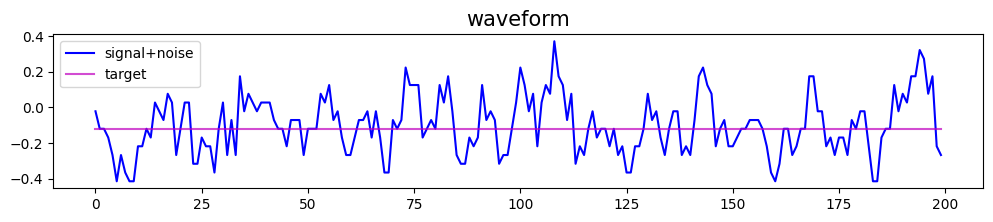

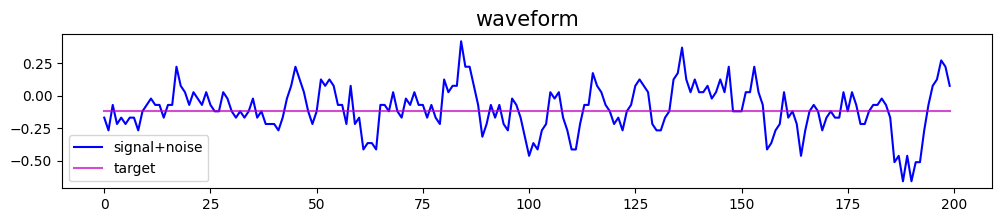

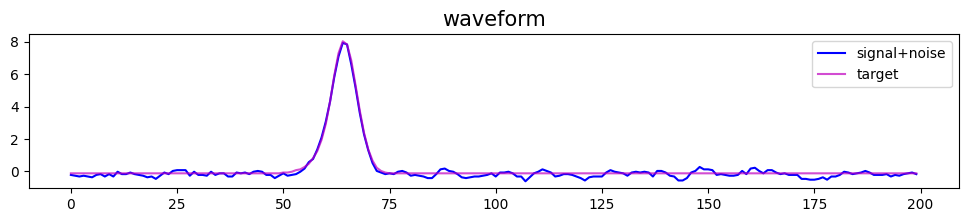

In [5]:
for idx in range(6,9):
    fig, (ax1) = plt.subplots(figsize=(12, 2), facecolor='white')
    ax1.plot(x_train_scaled[idx],color='blue', label='signal+noise')
    ax1.plot(y_train_scaled[idx],color='m',alpha=0.7, label='target')
    ax1.set_title("waveform", fontsize=15)
    ax1.legend()

    plt.show()

In [6]:
batch_size_ = 2048

In [7]:
model1 = load_model('../models/model_AE_'+str(batch_size_)+'_mirrored_1dcnn' + wireplane + 'plane_nu.h5')
model2 = load_model('../models/model_AE_'+str(batch_size_)+'_modified' + wireplane + 'plane_nu.h5')
model3 = load_model('../models/model_AE_'+str(batch_size_)+'_no_pooling' + wireplane + 'plane_nu.h5')
model4 = load_model('../models/model_AE_'+str(batch_size_)+'_FCN_' + wireplane + 'plane_nu.h5')

In [8]:
cnn = load_model('../../ROI_models/model_'+wireplane+'plane_nu_ROI.h5')
cnn_pred = cnn.predict(x_test_scaled, batch_size=4096)
cnn_pred = cnn_pred.squeeze()

25/25 [==============================] - 0s 11ms/step


In [9]:
x_test_ = std*x_test_scaled+mean
y_test_ = y_test_scaled*std + mean

In [10]:
%%time
predictions1 = model1.predict(x_test_scaled, batch_size=4096)
predictions1 = predictions1.reshape(predictions1.shape[0], predictions1.shape[1])

predictions2 = model2.predict(x_test_scaled, batch_size=4096)
predictions2 = predictions2.reshape(predictions2.shape[0], predictions2.shape[1])

predictions3 = model3.predict(x_test_scaled, batch_size=4096)
predictions3 = predictions3.reshape(predictions3.shape[0], predictions3.shape[1])

predictions4 = model4.predict(x_test_scaled, batch_size=4096)
predictions4 = predictions4.reshape(predictions4.shape[0], predictions4.shape[1])


25/25 [==============================] - 9s 367ms/step
CPU times: user 51.7 s, sys: 320 ms, total: 52.1 s
Wall time: 13.7 s


In [11]:
pred1 = predictions1*std+mean
pred2 = predictions2*std+mean
pred3 = predictions3*std+mean
pred4 = predictions4*std+mean

In [12]:
# takes in prediction of AE and for every wave assigns 0 or 1
# 0 --> predicted as noise
# 1 --> pricicted as containing some kind of signals
# note that this is crude and does not consider how close the predicted signal is from truth
def label_predictions(ae_pred_wave):
    label_ = 0
    if max(abs(ae_pred_wave)) > 3:
        label_ = 1
    return label_


def label_truths(wave):
    label_ = 1
    if max(abs(wave)) <= 3:
        label_ = 0
    return label_

In [13]:
pred_labels1 = [label_predictions(wave) for wave in pred1]
pred_labels2 = [label_predictions(wave) for wave in pred2]
pred_labels3 = [label_predictions(wave) for wave in pred3]
pred_labels4 = [label_predictions(wave) for wave in pred4]
truth_labels = [label_truths(t_wave) for t_wave in y_test_]

In [20]:
def merge_pdfs(min_cnn, max_cnn):
    merger = PdfMerger()
    path = 'pdfs/tmp/'
    pdf_files = [path+f for f in listdir(path) if (isfile(join(path, f)))]
    #print(pdf_files)

    for pdf_file in pdf_files:
        #Append PDF files
        merger.append(pdf_file)
        #merger.write('pdfs/plts_tmp/plts_' + wireplane + '_cnn_'+str(int(min_cnn*100)) + '-' + str(int(max_cnn*100)) + '_' + str(num_pages) +  'pages.pdf')
        merger.write('pdfs/'+wireplane+'/plts_' + wireplane + '_cnn_'+str(int(min_cnn*100)) + '-' + str(int(max_cnn*100)) + '_NOISE.pdf')
    merger.close()

    for file in pdf_files:
        os.remove(file)

In [21]:
type(pred1[0])

numpy.ndarray

In [22]:
def mse(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    actual = (actual-mean)/std
    pred = (pred-mean)/std
    return round(np.square(np.subtract(actual,pred)).mean(), 4)

In [23]:

def make_pdfs(min_cnn, max_cnn, num_pages):
    pages = 0
    for idx in range(10000):
        if pages < num_pages:
            if cnn_pred[idx] > min_cnn and cnn_pred[idx] <= max_cnn and sum(abs(y_test_[idx])) == 0:
                fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))
                fig.suptitle('CNN prediction: ' + str(round(cnn_pred[idx], 4)), fontsize=16)
                ax1.plot(x_test_[idx], color='black', alpha=0.3, label='input')
                ax1.plot(y_test_[idx], color='blue', alpha=0.9, label='truth ----- ' + str(truth_labels[idx]))
                ax1.plot(pred1[idx], color='m', alpha=0.7, label='pred ----- ' + str(pred_labels1[idx]))

                ax1.set_title('model 1: mirrored 1dcnn roi finder (MSE: ' + str(mse(y_test_[idx], pred1[idx])) + ')', fontsize=15)
                ax1.legend(fontsize=12)

                ax2.plot(x_test_[idx], color='black', alpha=0.3, label='input')
                ax2.plot(y_test_[idx], color='blue', alpha=0.9, label='truth ----- ' + str(truth_labels[idx]))
                ax2.plot(pred2[idx], color='m', alpha=0.7, label='pred ----- ' + str(pred_labels2[idx]))
                ax2.set_title('model 2: fully Conv1D (MSE: ' + str(mse(y_test_[idx], pred2[idx])) + ')', fontsize=15)
                ax2.legend(fontsize=12)
                
                ax3.plot(x_test_[idx], color='black', alpha=0.3, label='input')
                ax3.plot(y_test_[idx], color='blue', alpha=0.9, label='truth ----- ' + str(truth_labels[idx]))
                ax3.plot(pred3[idx], color='m', alpha=0.7, label='pred ----- ' + str(pred_labels3[idx]))
                ax3.set_title('model 3: no pooling (MSE: ' + str(mse(y_test_[idx], pred3[idx])) + ')', fontsize=15)
                ax3.legend(fontsize=12)

                ax4.plot(x_test_[idx], color='black', alpha=0.3, label='input')
                ax4.plot(y_test_[idx], color='blue', alpha=0.9, label='truth ----- ' + str(truth_labels[idx]))
                ax4.plot(pred4[idx], color='m', alpha=0.7, label='pred ----- ' + str(pred_labels4[idx]))
                ax4.set_title('model 4: FCN paper (MSE: ' + str(mse(y_test_[idx], pred4[idx])) + ')', fontsize=15)
                ax4.legend(fontsize=12)

                for ax in fig.get_axes():
                    ax.label_outer()
                plt.savefig('pdfs/tmp/test' + str(idx) +  '.pdf',
                    dpi=300,
                    bbox_inches='tight', pad_inches=0.75)
                plt.close()
                pages += 1
            else:
                continue
    merge_pdfs(min_cnn, max_cnn)

In [24]:
make_pdfs(0.94, 1, 20)

In [25]:
min_ = 0.94
prev = min_
max_ = 1
while min_ > 0:
    min_ = min_ - 0.2 
    make_pdfs(min_, prev,20)
    prev = min_
